# Simulación con simpy

jupyter para entender q es esto de simpy, no cachaba nada de los videos asi que hice esto, basicamente un copy paste de la pagina (link)[https://simpy.readthedocs.io/en/latest/simpy_intro/basic_concepts.html] despues de esto me hizo mas sentido como funciona simpy...

## Conceptos basicos



 
- Procesos (*process*): Los **procesos** modelan el comportamiento de las entidades (nuestro caso barcos etc)
- Entorno (*environment*): Los procesos viven en un **entorno** 

##### ¿Como simpy maneja los procesos?

Simpy maneja los procesos mediante [generadores](https://docs.python.org/3/glossary.html#term-generator), lo especial de este objeto es que retorna mediante el comando [yield](https://docs.python.org/3/reference/expressions.html#yieldexpr). Estos procesos crean eventos y los retornan (*yield/producen*)

Supongamos que ocurre un evento, el proceso (generador) queda suspendido, aqui simpy reanuda el proceso cuando el evento ocurre (se dice que el evento es procesado). Muchos procesos pueden esperar por el mismo evento y simpy los reanuda en el mismo orden en el cual ellos prudujieron (yielded) ese evento.

- **Timeout**: El **timeout** es un tipo de evento especial, este evento especial A procesado/ocurre despues de un cierto timepo este tipo de evento especial permite a un proceso a dormir (sleep) es decir que se queda pausado un cierto intervalo de tiempo

In [1]:
import simpy
################################# Ejemplo de un generador #############################3
# Una vez que una funcion tenga el termino yield se transforma en un generador
def gen():  
    yield 1
    yield 2

# iteracion 1: gen retorna 1 y el generador queda suspendido, luego se hace print del valor producido/yield
# iteracion 2: gen deja de estar suspendido y retorna el siguiente yield, es decir el 2

for i in gen():
    print(i)

# Notar que printer() no es una lista
print(gen())

############################# Ejemplo  simpy

# Se define el proceso CAR el cual simulara el parking de autos 

# Un auto va a a conducir y aparcar alternando
def car(env):

    while True:
        # Aparca el vehiculo
        print('Start parking at %d' % env.now)
        parking_duration = 5
        yield env.timeout(parking_duration)

        # Vuelve a conducir el vehiculo
        print('Start driving at %d' % env.now)
        trip_duration = 2
        yield env.timeout(trip_duration)


# Creamos el entorno simpy que manejara los procesos
env = simpy.Environment()
# Añadidmos el proceso car() al entorno!
env.process(car(env))
# Ejecutamos la simulacion hasta 20 tiempos
env.run(until=20)

1
2
<generator object gen at 0x000001A143B0F8A0>
Start parking at 0
Start driving at 5
Start parking at 7
Start driving at 12
Start parking at 14
Start driving at 19


Notar que el proceso *car* necesita de input el entorno *env* para crear nuevos eventos, ejemplo este produce el evento de *timeout*, el flujo seria como sigue:

- car produce timout
- timeout sleep cierto timepo
- termina timeout (es procesado)
- simpy reanuda car


Tambien notemos que tenemos *env.now* el cual retorna el tiempo de la simulacion, 

## Interaccion entre procesos


**Process** retornado por *environment.process* se utiliza para la interaccion entre procesos, el ejemplo anterior creamos una interaccion entre el proceso *timeout* y el proceso *car* 

Los procesos son tecnicamente eventos, **si tu proceso produce algo este se queda en pausa y se reanuda cuando el proceso haya terminado**
Imagine una simulación de lavado de autos en la que los autos ingresan al túnel de lavado y esperan a que finalice el proceso de lavado. O una simulación de aeropuerto donde los pasajeros tienen que esperar hasta que finalice un control de seguridad.

Supongamos que el coche de nuestro último ejemplo se convirtió mágicamente en un vehículo eléctrico. Los vehículos eléctricos suelen tardar mucho tiempo en cargar sus baterías después de un viaje. Tienen que esperar hasta que la batería esté cargada antes de poder empezar a conducir de nuevo.



In [2]:
class Car(object):
    def __init__(self, env):
        self.env = env
        
        # Corre el proceso cada vez que la instancia es creada
        self.action = env.process(self.run())

    def run(self):
        while True:
            print('Start parking and charging at %d' % self.env.now)
            charge_duration = 5
            # Producimos el proceso que el proceso retornara (charge_duration = 5)
            # to wait for it to finish
            yield self.env.process(self.charge(charge_duration))

            # The charge process has finished and
            # we can start driving again.
            print('Start driving at %d' % self.env.now)
            trip_duration = 2
            yield self.env.timeout(trip_duration)

    def charge(self, duration):
        yield self.env.timeout(duration)

In [3]:
env = simpy.Environment() # Creamos el entorno
car = Car(env) # incializamos la instancia Car
env.run(until=15) # Iniciamos la simulacion hasta 15 tiempos

Start parking and charging at 0
Start driving at 5
Start parking and charging at 7
Start driving at 12
Start parking and charging at 14


## Interrupción de procesos

Imaginemos en el ejemplo anterior que no queremos que el auto electrico se carge completamente

In [4]:
def driver(env, car):
    yield env.timeout(3)
    car.action.interrupt()

class Car():
    def __init__(self, env):
        self.env = env
        self.action = env.process(self.run())

    def run(self):
        while True:
            print('Start parking and charging at %d' % self.env.now)
            charge_duration = 5
            # We may get interrupted while charging the battery
            try:
                yield self.env.process(self.charge(charge_duration))
            except simpy.Interrupt:
                # When we received an interrupt, we stop charging and
                # switch to the "driving" state
                print('Was interrupted. Hope, the battery is full enough ...')

            print('Start driving at %d' % self.env.now)
            trip_duration = 2
            yield self.env.timeout(trip_duration)

    def charge(self, duration):
        yield self.env.timeout(duration)

env = simpy.Environment()
car = Car(env)
env.process(driver(env, car)) # interrumpimos el proceso
env.run(until=15)

Start parking and charging at 0
Was interrupted. Hope, the battery is full enough ...
Start driving at 3
Start parking and charging at 5
Start driving at 10
Start parking and charging at 12


# Recursos compartidos

Simpy ofrece 3 tipos de recursos:

- resource: Recursos que respetan prioridades y anticipacion
- container: Recursos repartidos homogeneamente entre procesos
- store: Recursos posiblimente una cantidad ilimitdada


Un recurso que debemos modelar con esto es la capacidad actual del puerto!!, lo podemos ver como un recurso que puede llenarse no ilimitadamente por lo tanto descartamos container para la simulacion de capacidad de puertos


Consideremos el ejemlpo del auto supongamos ahora que este conduce a una estacion de carga electrica la cual tiene 2 posibles espacios de carga, si estan ocupados espera hasta que uno de estos se desocupe


In [5]:
def car(env, name, bcs, driving_time, charge_duration):
    # Simulate driving to the BCS
    yield env.timeout(driving_time)

    # Request one of its charging spots
    print('%s arriving at %d' % (name, env.now))
    with bcs.request() as req:
        yield req

        # Charge the battery
        print('%s starting to charge at %s' % (name, env.now))
        yield env.timeout(charge_duration)
        print('%s leaving the bcs at %s' % (name, env.now))

el metodo *request()* genera un evento el cual hace esperar hasta que este disponible tal recurso. Notar, que se utilizó with, esto se encarga automaticamente de liberar el recurso, sin with debemos usar *release()* una vez que se termine de usar el recurso


Cuando se libera un recurso el proceso que estaba esperando es reanudado y utuiliza rl recuros, se usa  un orden FIFO (first in—first out)

In [6]:
env = simpy.Environment()
bcs = simpy.Resource(env, capacity=1)
for i in range(50):
    env.process(car(env, 'Car %d' % i, bcs, i*2, 5))

env.run(until=10)

Car 0 arriving at 0
Car 0 starting to charge at 0
Car 1 arriving at 2
Car 2 arriving at 4
Car 0 leaving the bcs at 5
Car 1 starting to charge at 5
Car 3 arriving at 6
Car 4 arriving at 8


# Geometria


<!-- 

 ### ¿Que geometria se usa en la tierra?
 http://www.geo.hunter.cuny.edu/~jochen/gtech201/lectures/lec6concepts/Datums/The%20earths%20shape%20is%20a%20spheroid.htm:~:text=The%20earth's%20shape%20is%20a%20spheroid&text=Although%20the%20earth's%20shape%20is,ellipsoid%20that%20approximates%20a%20sphere.
 Una buena aproximación es usar la geometria esferica 

 Con esta geometria basicamente debemos encontrar la forma de calcular la distancia mas corta entre puntos en la esfera
 Cada punto en la esfera lo representamos por (latitud, longuitud) https://es.wikipedia.org/wiki/Coordenadas_geogr%C3%A1ficas

 Dado dos puntos en la esfera, cual es la curva más corta que los conecta?
 Para esto se necesita el concepto de https://en.wikipedia.org/wiki/Great_circle
 ### Como implementar?
 Una libreria que implementa esto es geopy

[Ejemplo de como se calcula la distancia mas corta](https://geopy.readthedocs.io/en/stable/#module-geopy.distance) -->

#### ¿Como manejar la geometria en este proyecto?

Según mi perspectiva, la mejor forma para abordar esto (si consideramos simular las rutas por coordenadas) es usando
**geodataframes** es decir un dataframe más una columna que especifica la geometria

La libreria geopandas tiene la clase *geopandas.GeoDataFrame* con la cual se puede cargar este tipo de objetos, un ejemplo de un geodataframe


| Barco   | Longitud (m) | Ancho (m) | Peso (toneladas) | Capacidad de personas | Geometría      |
|---------|--------------|-----------|-------------------|-----------------------|-----------------|
| barco 1  | 12           | 3         | 2.5               | 6                     | Point(lat, lon)   |
| barco 2    | 15           | 4         | 3.5               | 10                    | Point(15, 25)   |

Para representar la geometria usualmente se usa la libreria *shaply*, geopandas la guarda en un objeto especial *Geoserie*

**La ventaja de usar esto es que podemos especificar el sistema coordenado con el cual vamos a trabajar con el atributo csr**

Consideremos el siguiente ejemplo


In [7]:
import geopandas as gpd
from shapely.geometry import Point


# Crear un GeoDataFrame con un punto (latitud, longitud)
latitud = -33.47349532706206 ;longitud = -70.64913242179095 # COORDENADAS DE SANTAIGO

# Creamos un geodataframe

gdf= gpd.GeoDataFrame(geometry=[Point(longitud, latitud)], crs='EPSG:4326') # Sistema  World Geodetic System

gdf["nombre"]="barco_1"
################# AGREGANDO CRS MERCATOR
print("Geodataframe con csr geodesico")
print(gdf)
############################################
gdf = gdf.to_crs("EPSG:3395") # EPSG:3395 ES EL CSR DE LA PROYECCION MERCATOR
print("Geodataframe con csr mercator")
print(gdf)




# https://epsg.io/3395 proyeccion mercator


Geodataframe con csr geodesico
                      geometry   nombre
0  POINT (-70.64913 -33.47350)  barco_1
Geodataframe con csr mercator
                            geometry   nombre
0  POINT (-7864625.446 -3934756.563)  barco_1


## visualizando

<Axes: >

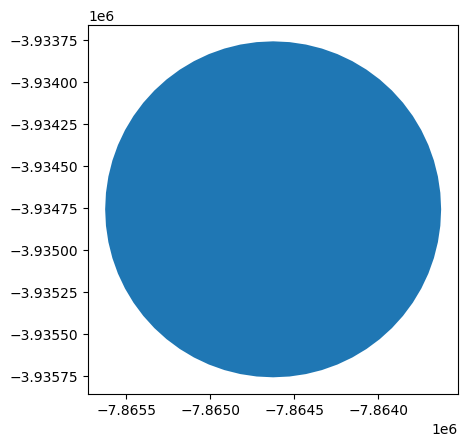

In [8]:
buffer = gdf.buffer(1000)  # 1000 metros

buffer_2 = gdf.buffer(100)  # 100 metros
buffer_gdf = gpd.GeoDataFrame(geometry=buffer, crs='EPSG:3395')
buffer_2gdf = gpd.GeoDataFrame(geometry = buffer_2, crs = 'EPSG:3395')
buffer_gdf.plot()
 


## Visualizando con folium

In [10]:
import folium

# Mostrar el mapa
m = folium.Map(location=[latitud,longitud],zoom_start=11)
folium.Marker([latitud, longitud], popup='Aquí estoy').add_to(m)

folium.GeoJson(buffer_gdf, name="hello world").add_to(m)

folium.GeoJson(buffer_2gdf, name="hello world").add_to(m)
m


![alternativo](operaciones_geometricas.png)
![ternativo](operaciones.png)
![Texto alternativo](mercator.png)


### 
####### Se puede usar geometria euclideana con puntos ya en la proyeccion mercator? 
https://math.stackexchange.com/questions/738529/distance-between-two-points-in-utm-coordinates

##### 
Quizas esto pueda ser util, hay una libreria que calcula la distancia mas corta entre dos puertos de la tierra
[Libreria: scgraph](https://stackoverflow.com/questions/68112636/is-there-any-python-package-available-to-calculate-shortest-distance-between-coo )
con esto podriamos adaptar la simulacion para cuando considere puertos reales